## Load Language Dataset Classification DataFrame

Here, we load a multi-language classification dataset. It was build using 26 version of the Bible each one of them coreresponding to a specific indigenous languages. Also, there is one version of the Portuguese. Therefore, the dataset consist of the more than 162 thousand of verses from the bible. 

In [ ]:
import unicodedata
import re
import pandas as pd
import numpy as np

In [ ]:
# Each document is a verse

def preprocess_corpora(df, classes_, n_samples=1000):
  
  frames = []
  for lang in classes_:
    frames.append(df[df['LANG']==lang].sample(n=n_samples)[['TEXT', 'LANG']])

  return pd.concat(frames).reset_index().sample(frac=1)

In [ ]:

# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                   if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
    w = unicode_to_ascii(w.strip().lower())

    # creating a space between a word and the punctuation following it eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping
    # -punctuation
    w = re.sub(r"([?.!,¿#@0-9])", r"", w)

    return w

#### Ploting Features from TF-IDF using T-SNE

In [ ]:
def adjust_lightness(color):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, 0.9 * c[1])), c[2])

In [ ]:
get_color_name = lambda rgba: matplotlib.colors.to_hex(rgba)

In [ ]:
bible_corpus = pd.read_csv('https://github.com/Tiagoblima/indigenous-corpus/raw/main/indigenous_cls.csv').replace('',np.nan).dropna()

In [ ]:
import random 
import matplotlib


classes = np.unique(bible_corpus['LANG'].tolist())
colors = random.sample(list(matplotlib.colors.cnames), k=27)
bible_corpus = preprocess_corpora(bible_corpus, n_samples=10, classes_=classes)
X = bible_corpus['TEXT'].apply(preprocess_sentence).to_numpy()

mymap = dict(zip(classes, list(map(get_color_name, map(adjust_lightness, colors)) )))


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:

pipe = Pipeline([
                    ('vect', CountVectorizer(analyzer='char', ngram_range=(2,3))),
                    ('tfidf', TfidfTransformer())

                  ])  
X_array =  pipe.fit_transform(X).toarray()
print(X_array.shape)
X_embedded = TSNE(n_components=2).fit_transform(X_array)

(270, 6782)


In [ ]:
df = pd.DataFrame(X_embedded, columns=['PCA1', 'PCA2'])
df['Language'] = bible_corpus['LANG'].tolist()
groups = df.groupby('Language')


In [ ]:
import matplotlib.pyplot as plt

Text(0.5, 0.98, 'Language Visualization')

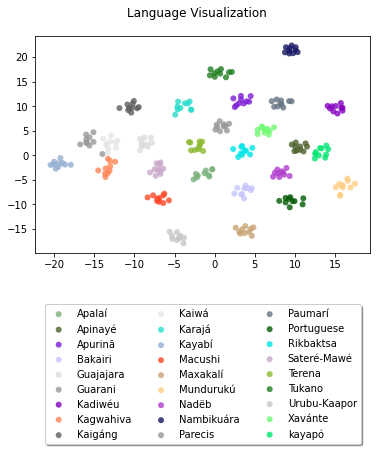

In [ ]:


fig, ax = plt.subplots()
for group in groups:    

    pca1, pca2 = group[1].loc[:,'PCA1'], group[1].loc[:,'PCA2']


    ax.scatter(pca1, pca2, c=mymap[group[0]], label=group[0],
               alpha=0.8, edgecolors='none')

ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.9),
          ncol=3, fancybox=True, shadow=True)
fig.suptitle('Language Visualization')

In [ ]:
bible_corpus = pd.read_csv('https://github.com/Tiagoblima/indigenous-corpus/raw/main/indigenous_cls.csv').replace('',np.nan).dropna()
bible_corpus['TEXT'] =  bible_corpus['TEXT'].apply(preprocess_sentence)

classes = np.unique(bible_corpus['LANG'].tolist())
bible_corpus = preprocess_corpora(bible_corpus, n_samples=1, classes_=classes)
X = bible_corpus['TEXT'].to_numpy()

In [ ]:
from nltk import ngrams

def get_ngrams(sent):
  return np.array(list(enumerate(map(''.join, ngrams(sent, 3)))), dtype=str)

#### Building Training Dataset

In [ ]:
bible_corpus = pd.read_csv('https://github.com/Tiagoblima/indigenous-corpus/raw/main/indigenous_cls.csv').replace('',np.nan).dropna()


In [ ]:
bible_corpus['TEXT'] =  bible_corpus['TEXT'].apply(preprocess_sentence)
classes = np.unique(bible_corpus['LANG'].tolist())
bible_corpus = preprocess_corpora(bible_corpus, n_samples=10, classes_=classes)
X = bible_corpus['TEXT'].to_numpy()

In [ ]:
os.mkdir('data')

In [ ]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
import os 

In [ ]:
experiments = []

#### Diferent Test Folds
for n in range(1, 11):
  rs = ShuffleSplit(n_splits=5, test_size=.2, random_state=22)
  os.mkdir('data/dataset'+str(n))
  for i,index in enumerate(rs.split(X),1):
    train_index, test_index = index
    train_df = bible_corpus.iloc[train_index]
    train_df = preprocess_corpora(train_df, classes, n_samples=n)
    train_df.to_csv(os.path.join('data/dataset'+str(n), 'train_'+str(i)+'.csv'), index=False, index_label=False)
    test_df = bible_corpus.iloc[test_index]
    test_df.to_csv(os.path.join('data/dataset'+str(n),'test_'+str(i)+'.csv'), index=False, index_label=False)

In [ ]:
lang_cls_large = pd.read_csv('https://github.com/Tiagoblima/indigenous-corpus/raw/main/lang_cls_large.csv').replace('',np.nan).dropna()
lang_cls_large.shape

(85252, 3)

In [ ]:
bible_corpus = pd.read_csv('https://github.com/Tiagoblima/indigenous-corpus/raw/main/indigenous_cls.csv').replace('',np.nan).dropna()
bible_corpus['TEXT'] =  bible_corpus['TEXT'].apply(preprocess_sentence)

classes = np.unique(bible_corpus['LANG'].tolist())
bible_corpus = preprocess_corpora(bible_corpus, n_samples=1000, classes_=classes)
X = bible_corpus['TEXT'].to_numpy()

In [ ]:
from sklearn.model_selection import ShuffleSplit
import os 

# Fixed Test Fold
rs = ShuffleSplit(n_splits=1, test_size=.2, random_state=22)

for index in rs.split(np.arange(0,lang_cls_large.shape[0])):
  train_index, test_index = index

  test_df = bible_corpus.iloc[test_index]
  test_df.to_csv(os.path.join('data/test.csv'), index=False, index_label=False)
  train_df = bible_corpus.iloc[train_index]

for n in range(1, 11):
  rs = ShuffleSplit(n_splits=5, test_size=.3, random_state=22)
  os.mkdir('data/dataset'+str(n))
  for i,index in enumerate(rs.split(X),1):
   
    val_df = preprocess_corpora(train_df, classes, n_samples=n)
    val_df.to_csv(os.path.join('data/dataset'+str(n), 'train_'+str(i)+'.csv'), index=False, index_label=False)


NameError: ignored

In [ ]:
!zip -r data.zip data
from google.colab import files
files.download('data.zip')

In [ ]:
!sudo rm -r data 

In [ ]:
df = pd.read_csv('indigenous_aligned_text.csv').loc[[1], ].drop(columns=['Book', 'Chapter', 'Verse']).T

In [ ]:
from nltk import ngrams

get_ngrams = lambda sentence: ', '.join(list(map(''.join,ngrams(sentence, 3)))).lower()


In [ ]:
get_ngrams('Hello World')

In [ ]:
df.columns = ['sentences']
df['sentences'] = df['sentences'].apply(get_ngrams)
open('text.txt','w').write(df.to_latex())

### Selecting Most Important Features 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split


In [ ]:
bible_corpus = pd.read_csv('https://github.com/Tiagoblima/indigenous-corpus/raw/main/indigenous_cls.csv').replace('',np.nan).dropna()
bible_corpus['TEXT'] =  bible_corpus['TEXT'].apply(preprocess_sentence)
classes = np.unique(bible_corpus['LANG'].tolist())
bible_corpus = preprocess_corpora(bible_corpus, n_samples=1, classes_=classes)
X = bible_corpus['TEXT'].to_numpy()
y = bible_corpus['LANG'].to_numpy()

#### Selection from all N-grams

In [ ]:
def get_importance(X, label):
  count = CountVectorizer(analyzer='char', ngram_range=(2,3))
  X_count = count.fit_transform(X)
  tfidf = TfidfTransformer()
  
  X_array =  tfidf.fit_transform(X_count).toarray()
  X_array.shape
  sel = SelectFromModel(RandomForestClassifier(n_estimators = 10))
  sel.fit(X_array,  label)
  importance = np.take(X_array, sel.get_support().nonzero()[0], axis=1)
  ngrams_feats = np.array(count.get_feature_names())
  top_idx = np.take((-importance).argsort(), range(10), axis=1)
  top_ngrams = np.take([count.get_feature_names()],top_idx, axis=1)
  return top_ngrams.squeeze()

In [ ]:
pd.DataFrame(get_importance(X, y), index=classes).to_latex()

"\\begin{tabular}{lllllllllll}\n\\toprule\n{} &    0 &    1 &    2 &    3 &    4 &    5 &    6 &    7 &    8 &    9 \\\\\n\\midrule\nApalaí       &   bi &   my &   ju &   ao &   ae &   je &   is &   mb &   hy &   aa \\\\\nApinayé      &   ao &   a  &   cr &   es &   ac &   e' &   lu &    ' &   er &   ge \\\\\nApurinã      &   ao &   mr &   nx &   my &   mi &   nu &   e' &   'u &   bo &   bi \\\\\nBakairi      &    g &   'r &   je &   ey &   kɨ &   ao &   hy &   a' &   kw &   ka \\\\\nGuajajara    &   es &   aw &   ao &   av &   at &   nd &   ar &   em &   cr &    d \\\\\nGuarani      &    k &   la &   le &   eh &    a &   it &   ip &    ' &   ge &   ia \\\\\nKadiwéu      &   no &   ao &   da &   a² &   ky &   'm &   el &   aɡ &   ic &   aa \\\\\nKagwahiva    &   aw &   es &   cr &   ao &   je &   et &   cu &    g &   aa &   mb \\\\\nKaigáng      &   ao &   es &   nx &   ic &   a  &   iw &   ac &    a &   e' &   av \\\\\nKaiwá        &   ao &    a &   ju &   ip &   ge &   ji &   mb &   

### Selection by each document

In [ ]:
top_ngrams = []
for i in range(27):
  text = bible_corpus[bible_corpus['LANG']==classes[i]]['TEXT'].to_numpy()
  top_ngrams.append(get_importance(text, [classes[i]]))
  print(i)
  print(classes[i], get_importance(text, [classes[i]]))

In [ ]:
pd.DataFrame(np.array(top_ngrams), index=classes).to_latex()

"\\begin{tabular}{lllllllllll}\n\\toprule\n{} &   0 &    1 &    2 &    3 &    4 &    5 &    6 &    7 &    8 &    9 \\\\\n\\midrule\nApalaí       &  o  &   ar &   ro &   e  &   a  &   ko &   se &   ma &    k &  aro \\\\\nApinayé      &  a  &   e  &    k &    m &   me &    a &   me &    n &   am &  me  \\\\\nApurinã      &  i  &   ri &   a  &   ar &   ak &   ki &   ka &  ari &   at &  ri  \\\\\nBakairi      &  a  &    i &   ry &  ymo &   ar &  ary &  una &   un &   mo &  ry  \\\\\nGuajajara    &  he &   e  &  he  &    a &  ehe &   eh &   r  &  ar  &   ar &   aꞌ \\\\\nGuarani      &  e  &   ꞌe &   i  &  ꞌe  &   aꞌ &  aꞌe &   a  &   ra &   nh &   te \\\\\nKadiwéu      &   n &   ni &   ni &   di &   ig &   i  &   aɡ &   gi &   e  &  aɡa \\\\\nKagwahiva    &  a  &   i  &  ga  &    p &   ga &   o  &   e' &   mb &   'g &   mo \\\\\nKaigáng      &   t &   e  &   g  &   y  &   n  &   i  &   ja &    h &   ag &   ti \\\\\nKaiwá        &  e  &   ha &    n &   nh &   an &   nd &  nha &   nh &  han &